In [61]:
import pandas as pd
import numpy as np
import scipy
import pylab as pl
import sklearn as sk
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_excel('HealthViz County Dataset 6.19.17.xlsx',skiprows=0, header=1, index_col=0)
data.index.name=None

In [3]:
data.shape

(3220, 41)

In [4]:
data.head()

,Unnamed: 1,"Population (residents), 2011-2015","Median household income, 2011-2015","Per capita income, 2011-2015","Gini index of income inequality, 2015","Food stamps (SNAP) (% of households), 2011-2015","Poverty rate (% of residents), 2011-2015","Median property tax ($), 2011-2015","Rent-burdened (% of renter-occupied housing units), 2011-2015","Median gross rent, 2011-2015",...,"Medicare inpatient utilization (% of beneficiaries), 2015","Current cigarette smoking (% of adults), 2006-2012","Diagnosed diabetes (% of adults), 2006-2012","High blood pressure (% of adults), 2006-2012","Obesity (% of adults), 2006-2012","Mortality rate, all causes (deaths per 100,000), 2008-2014","Diabetes mortality (deaths per 100,000), 2008-2014","Influenza and pneumonia mortality (deaths per 100,000), 2008-2014","Septicemia (sepsis) mortality (deaths per 100,000), 2008-2014","Years of potential life lost (YPLL) (life-years lost per 100,000), 2012-2014"
1001,"Autauga County, AL",55221,51219.97561,24974.0,NaN,13.777211,12.879382,455.0,49.407783,881.94923,...,18.20,21.0,10.8,27.3,29.2,917.2,21.5,17.7,19.1,9158.2
1003,"Baldwin County, AL",195121,50194.19774,27317.0,0.4722,9.003563,13.411661,573.0,44.544464,877.95399,...,16.23,22.7,7.5,30.9,25.0,792.7,17.5,10.5,10.0,7393.9
1005,"Barbour County, AL",26932,32924.77284,16824.0,NaN,25.970505,26.727439,301.0,40.946992,578.31099,...,17.60,25.2,11.3,46.4,46.1,914.3,19.4,12.0,12.7,8573.1
1007,"Bibb County, AL",22604,38631.97318,18431.0,NaN,15.781984,16.795878,266.0,35.162950,650.22531,...,17.81,25.6,9.2,39.1,30.5,1029.3,24.5,17.0,20.1,11766.1
1009,"Blount County, AL",57710,45758.48253,20532.0,NaN,13.489623,16.720933,419.0,31.117687,600.28481,...,15.98,22.4,8.6,36.2,34.4,907.0,13.8,32.4,20.8,9332.8


In [5]:

def cov(x,y,w=None):
    '''
    Calculates covariance of x,y weighted by w.
    Parameters
        x,y: pd.Series
        w: pd.Series or None
    Returns
        covariance: float
    '''
    if w is None:
        w = pd.Series(np.ones(x.shape[0]))
        w.index = x.index
        
    numerator = sum(w*(x - np.average(x, weights=w))*(y - np.average(y, weights=w)))
    denominator = sum(w)
    return numerator/denominator

def corr(x, y, w=None, check_nulls = False):
    '''
    Calculates Pearson correlation between x,y weighted by w.
    Parameters
        x,y: pd.Series
        w: pd.Series or None
        check_nulls: Boolean, optional 
    Returns
        covariance: float
    '''
    if w is None:
        w = pd.Series(np.ones(x.shape[0]))
        w.index = x.index
    
    if check_nulls:
        df = pd.concat([x, y, w], axis = 1)
        null_cols  = df.isnull().any(axis = 1)
    
        if null_cols.any():
            x = x[~null_cols]
            y = y[~null_cols]
            w = w[~null_cols]

    return cov(x,y,w)/np.sqrt(cov(x,x,w)*cov(y,y,w))



In [6]:
def df_corr(xs, ys, w=None, method=corr, min_periods=1):
        """
        Compute pairwise correlation of columns, excluding NA/null values
        Parameters
        ----------
        min_periods : int, optional
            Minimum number of observations required per pair of columns
            to have a valid result. 
        Returns
        -------
        y : DataFrame
        
        Modified from pandas:
            https://github.com/pandas-dev/pandas/blob/v0.20.2/pandas/core/frame.py#L4817-L4871
        """
        if isinstance(xs, pd.Series):
            xs = pd.DataFrame(xs)
            
        rows = xs.columns
       
        if isinstance(ys, pd.Series):
            ys = pd.DataFrame(ys)
            
        cols = ys.columns
            
        xmat = xs.values.T
        ymat = ys.values.T

        if min_periods is None:
            min_periods = 1
        #mat = _ensure_float64(mat).T
        corrf = method
        K = len(rows)
        M = len(cols)
        correl = np.empty((K, M), dtype=float)
        xmask = np.isfinite(xmat)
        ymask = np.isfinite(ymat)
        for i, ac in enumerate(xmat):
            for j, bc in enumerate(ymat):
                valid = xmask[i] & ymask[j]
                
                if valid.sum() < min_periods:
                    c = NA
                elif not valid.all():
                    c = corrf(ac[valid], bc[valid], w[valid])
                else:
                    c = corrf(ac, bc, w)
                correl[i, j] = c

        return pd.DataFrame(correl, index=rows, columns=cols)

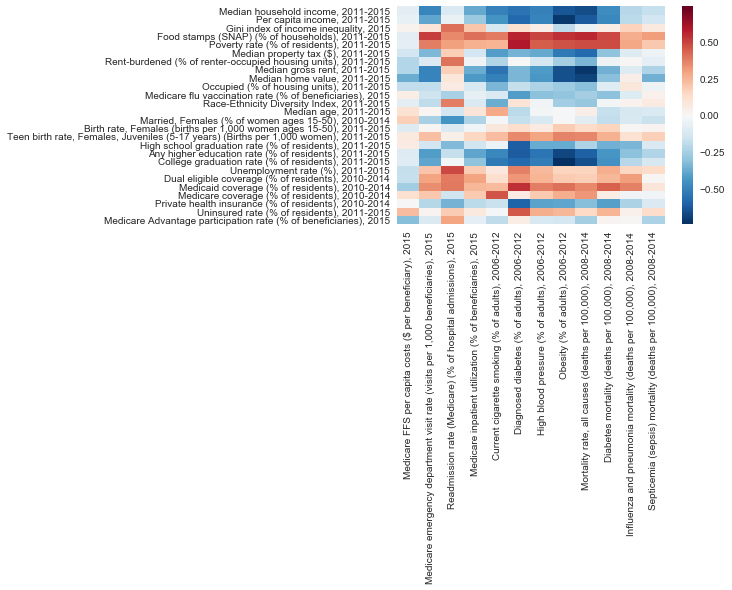

In [7]:
w = data.ix[:,1]
xs = data.ix[:,2:28]
ys = data.ix[:,28:-1]
crs = df_corr(xs,ys,w)
sns.heatmap(crs)

In [8]:
crs

,"Medicare FFS per capita costs ($ per beneficiary), 2015","Medicare emergency department visit rate (visits per 1,000 beneficiaries), 2015","Readmission rate (Medicare) (% of hospital admissions), 2015","Medicare inpatient utilization (% of beneficiaries), 2015","Current cigarette smoking (% of adults), 2006-2012","Diagnosed diabetes (% of adults), 2006-2012","High blood pressure (% of adults), 2006-2012","Obesity (% of adults), 2006-2012","Mortality rate, all causes (deaths per 100,000), 2008-2014","Diabetes mortality (deaths per 100,000), 2008-2014","Influenza and pneumonia mortality (deaths per 100,000), 2008-2014","Septicemia (sepsis) mortality (deaths per 100,000), 2008-2014"
"Median household income, 2011-2015",-0.078551,-0.488691,-0.113363,-0.379721,-0.503416,-0.546032,-0.499706,-0.634078,-0.664253,-0.464039,-0.206504,-0.168147
"Per capita income, 2011-2015",-0.059137,-0.391643,-0.050106,-0.277413,-0.441639,-0.583678,-0.497832,-0.714107,-0.623472,-0.478021,-0.201713,-0.135658
"Gini index of income inequality, 2015",0.027880,0.094896,0.410381,0.206067,-0.124187,0.121395,0.051298,-0.195172,-0.049095,0.055589,0.168864,0.075316
"Food stamps (SNAP) (% of households), 2011-2015",-0.079888,0.513043,0.354434,0.408423,0.385150,0.562364,0.500838,0.544174,0.558794,0.488769,0.270977,0.311705
"Poverty rate (% of residents), 2011-2015",-0.070911,0.382318,0.302886,0.265188,0.254274,0.593456,0.450696,0.473008,0.481717,0.481312,0.289662,0.201975
"Median property tax ($), 2011-2015",-0.137083,-0.335303,0.180412,-0.133325,-0.416195,-0.352521,-0.379809,-0.529035,-0.575380,-0.299804,-0.095771,-0.037578
"Rent-burdened (% of renter-occupied housing units), 2011-2015",-0.217213,-0.106719,0.403068,-0.031934,-0.223791,0.004210,-0.132136,-0.253572,-0.340989,-0.035887,0.007097,-0.073728
"Median gross rent, 2011-2015",-0.216222,-0.495552,0.174236,-0.370514,-0.545749,-0.338240,-0.420302,-0.650573,-0.720465,-0.359218,-0.098495,-0.228980
"Median home value, 2011-2015",-0.367853,-0.495343,0.087802,-0.425724,-0.509472,-0.341804,-0.433022,-0.652575,-0.685987,-0.310440,0.050310,-0.357029
"Occupied (% of housing units), 2011-2015",-0.183135,-0.181269,0.062724,-0.115936,-0.340733,-0.178317,-0.229821,-0.269347,-0.309640,-0.088177,0.084008,-0.039978


In [9]:
def ordered_corrs(xs, y, w):
    '''
    '''
    crs = df_corr(xs,y,w)
    return crs.reindex(crs.ix[:,0].abs().sort_values(ascending=False).index).ix[:,0]

def ordered_heatmap(crs):
    pl.figure()
    sns.heatmap(pd.DataFrame(crs), vmin = -.8, vmax = .8)
    pl.show()

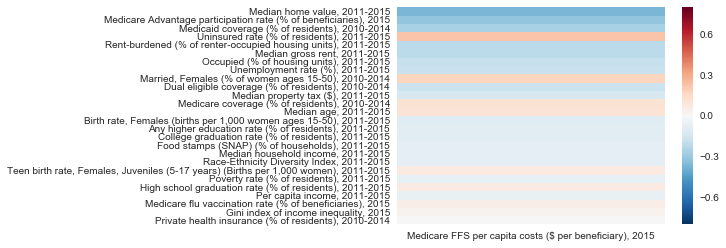

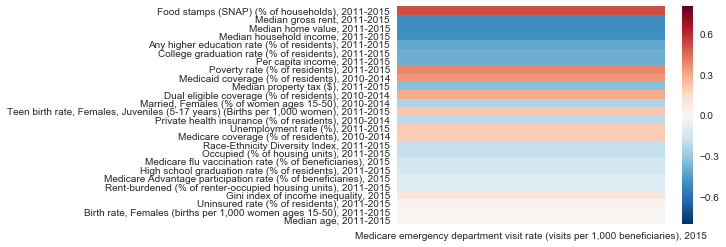

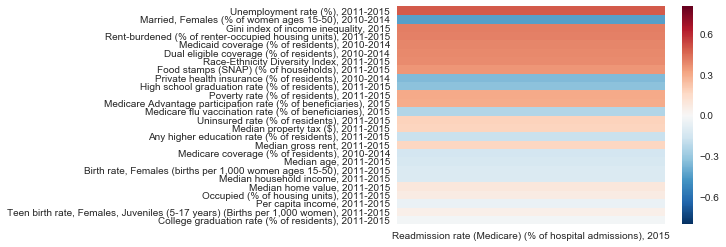

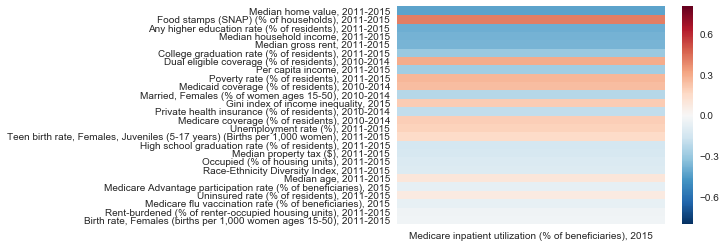

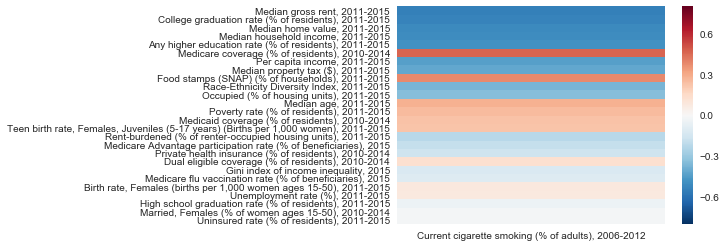

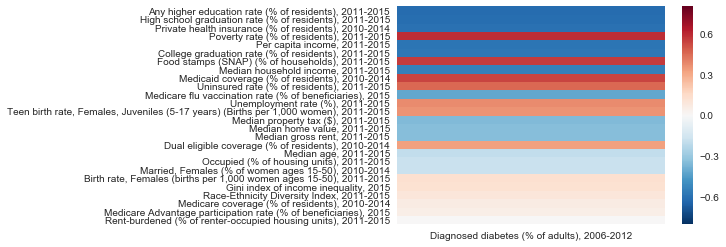

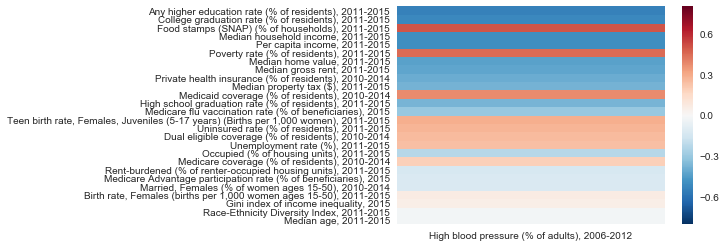

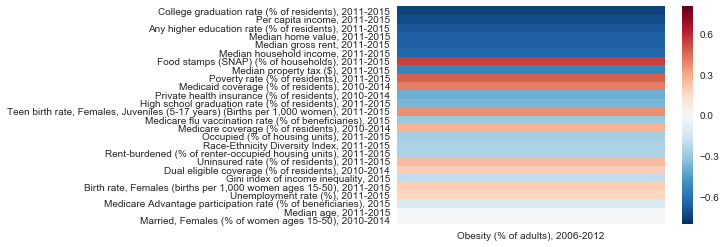

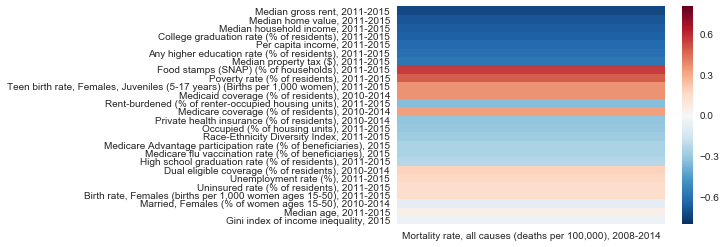

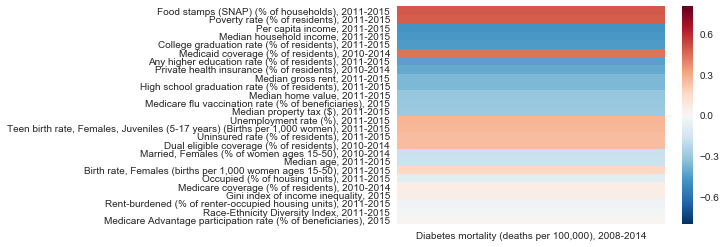

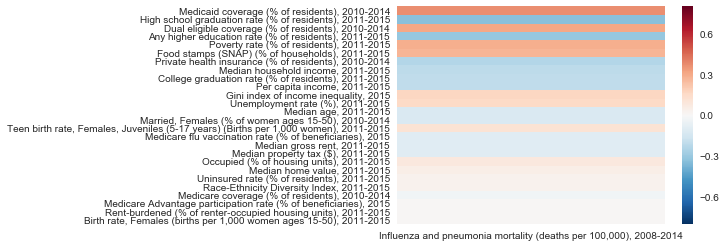

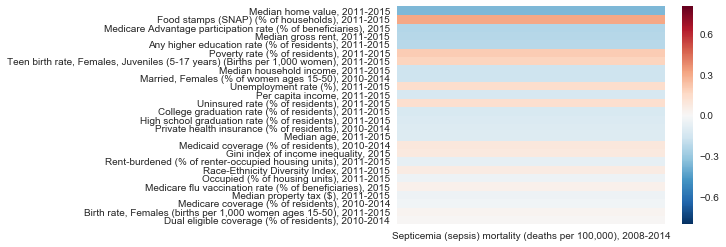

In [10]:
for y in ys:
    ordered_heatmap(ordered_corrs(xs,ys[y], w))


In [70]:
def highest_crs(xs, ys, w):
    '''
    Get the highest absolute correation social determinant for each health outcome
    '''
    yl = []
    xl = []
    crsl = []
    d = {}
    for y in ys:
        yl.append(y)
        xl.append((ordered_corrs(xs,ys[y], w)).abs().idxmax())
        crsl.append((ordered_corrs(xs,ys[y], w)).iloc[0])
    d['Health Outcomes'] = yl
    d['Social Determinants'] = xl
    d['Correlation'] = crsl
    df = pd.DataFrame(d)
    return df

In [72]:
highest_crs(xs, ys, w)

,Correlation,Health Outcomes,Social Determinants
0,-0.367853,Medicare FFS per capita costs ($ per beneficia...,"Median home value, 2011-2015"
1,0.513043,Medicare emergency department visit rate (visi...,"Food stamps (SNAP) (% of households), 2011-2015"
2,0.488829,Readmission rate (Medicare) (% of hospital adm...,"Unemployment rate (%), 2011-2015"
3,-0.425724,Medicare inpatient utilization (% of beneficia...,"Median home value, 2011-2015"
4,-0.545749,"Current cigarette smoking (% of adults), 2006-...","Median gross rent, 2011-2015"
5,-0.616306,"Diagnosed diabetes (% of adults), 2006-2012","Any higher education rate (% of residents), 20..."
6,-0.539963,"High blood pressure (% of adults), 2006-2012","Any higher education rate (% of residents), 20..."
7,-0.741944,"Obesity (% of adults), 2006-2012","College graduation rate (% of residents), 2011..."
8,-0.720465,"Mortality rate, all causes (deaths per 100,000...","Median gross rent, 2011-2015"
9,0.488769,"Diabetes mortality (deaths per 100,000), 2008-...","Food stamps (SNAP) (% of households), 2011-2015"


In [151]:
def crs_table(xs, y, w):
    label = ['Strong Negative', 'Moderate Negative ', 
             'Weak Negative', 'No Linear Relationship', 'Weak Positive', \
             'Moderate Positive', 'Strong Positive']
    d = {}
    l_list = []
    data = ordered_corrs(xs, y, w)
    bins = pd.cut(data, [-1.0, -0.7, -0.5, -0.3, 0.3, 0.5, 0.7, 1.0], right=False)
    cols = pd.crosstab(data.index, bins)
    for col in cols:
        l = cols.loc[cols[col] == True].index.tolist()
        l_list.append(l)
    d['Level'] = label
    d['Social Determinants'] = l_list
    l_list = []
    df = pd.DataFrame(d)
    print (df)
    return (df)

In [152]:
for y in ys:
    print ('Health Outcome:', y)
    crs_table(xs,ys[y], w)
    print ()
    print ()

Health Outcome: Medicare FFS per capita costs ($ per beneficiary), 2015
                    Level                                Social Determinants
0         Strong Negative                                                 []
1      Moderate Negative                                                  []
2           Weak Negative  [Median home value, 2011-2015, Medicare Advant...
3  No Linear Relationship  [Any higher education rate (% of residents), 2...
4           Weak Positive                                                 []
5       Moderate Positive                                                 []
6         Strong Positive                                                 []


Health Outcome: Medicare emergency department visit rate (visits per 1,000 beneficiaries), 2015
                    Level                                Social Determinants
0         Strong Negative                                                 []
1      Moderate Negative                                    